# PINN Example
Burgers example $u=...$

at $t=0$ , sine function (boundary_t0)

at sides $t \in [0,1], u=0$ (open_boundary)

In [1]:
# PINN in jupyter test, from 
# https://github.com/tum-pbs/PhiFlow/blob/1.5/demos/PINN_burgers.py
# https://colab.research.google.com/drive/1S21OY8hzh1oZK2wQyL3BNXvSlrMTtRbV#offline=true&sandboxMode=true

from phi.tf.flow import *

#rnd = TF_BACKEND  # sample different points in the domain each iteration
rnd = math.choose_backend(1)  # use same random points for all iterations


def network(x, t):
    """ Dense neural network with 8 hidden layers and 3021 parameters in total.
        Parameters will only be allocated once (auto reuse).
    """
    y = math.stack([x, t], axis=-1)
    for i in range(8):
        y = tf.layers.dense(y, 20, activation=tf.math.tanh, name='layer%d' % i, reuse=tf.AUTO_REUSE)
    return tf.layers.dense(y, 1, activation=None, name='layer_out', reuse=tf.AUTO_REUSE)


def f(u, x, t):
    """ Physics-based loss function with Burgers equation """
    u_t = gradients(u, t)
    u_x = gradients(u, x)
    u_xx = gradients(u_x, x)
    return u_t + u*u_x - (0.01 / np.pi) * u_xx


def boundary_t0(N):
    x = rnd.random_uniform([N], -1, 1)
    t = rnd.zeros_like(x)
    u = - math.sin(np.pi * x)
    return x, t, u


def open_boundary(N):
    t = rnd.random_uniform([N], 0, 1)
    x = math.concat([math.zeros([N//2]) + 1, math.zeros([N//2]) - 1], axis=0)
    u = math.zeros([N])
    return x, t, u



Could not load resample cuda libraries: CUDA binaries not found at /Users/thuerey/Dropbox/mbaDevelSelected/phiflow-v1.5/phi/tf/cuda/build/resample.so. Run "python setup.py cuda" to compile them





/Users/thuerey/Dropbox/mbaDevelSelected/phiflow-v1.5/phi/tf/flow.py:15: UserWarning: TensorFlow-CUDA solver is not available. To compile it, download phiflow sources and run
$ python setup.py tf_cuda
before reinstalling phiflow.
  warnings.warn("TensorFlow-CUDA solver is not available. To compile it, download phiflow sources and run\n$ python setup.py tf_cuda\nbefore reinstalling phiflow.")


Setup sampling points in inner domain

In [2]:
# generate array with positions: 
#   -1 to 1 spatial with 128 cells
#   0 to 1 in time with 1+32 timesteps
grids_xt = np.meshgrid(np.linspace(-1, 1, 128), np.linspace(0, 1, 33), indexing='ij')
grid_x, grid_t = [tf.convert_to_tensor(t, tf.float32) for t in grids_xt]

# # gx ,gt = 
# #[tf.convert_to_tensor(t, tf.float32) 
# # for t in np.meshgrid( np.linspace(-1, 1, 128), np.linspace(0, 1, 33), indexing='ij')]

# for t in np.meshgrid( np.linspace(-1, 1, 128), np.linspace(0, 1, 33), indexing='ij'):
#     print(format(t.shape))
#     print(format(t))

# #tx = np.meshgrid( np.linspace(-1, 1, 128), indexing='ij')
# print(format(grid_x))
# print(format(grid_x.shape))

# create 4D tensor with batch and channel dimensions in addition to space and time
# in this case gives shape=(1, 128, 33, 1)
grid_u = math.expand_dims(network(grid_x, grid_t))

Instructions for updating:
Use keras.layers.Dense instead.
Instructions for updating:
Please use `layer.__call__` method instead.


In [ ]:
Helper to show

(1, 128, 33, 1)
(128, 528)


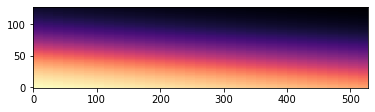

In [4]:
# test image output
import matplotlib.pyplot
print(grid_u.shape)

session = Session(None)
session.initialize_variables()

def show_state(a):
    global session
    a = session.run(a)

    # we only have 33 time steps, blow up by a factor of 2^4 to make it easier to see
    # (could also be done with more evaluations of network)
    for i in range(4):
        a = np.concatenate( [a,a] , axis=3)
    a = np.reshape( a, [a.shape[1],a.shape[2]*a.shape[3]] )

    print(a.shape)
    matplotlib.pyplot.imshow(a, origin='lower', cmap='magma')
    
show_state(grid_u)

In [49]:
# Boundary loss
num_sample_points_bnd = 100
x_bc, t_bc, u_bc = [math.concat([v_t0, v_x], axis=0) for v_t0, v_x in zip(boundary_t0(num_sample_points_bnd), open_boundary(num_sample_points_bnd))]
#with app.model_scope():
loss_u = math.l2_loss(network(x_bc, t_bc)[:, 0] - u_bc)  # normalizes by first dimension, N_bc

# Physics loss inside of domain
num_sample_points_inner = 1000
x_ph, t_ph = tf.convert_to_tensor(rnd.random_uniform([num_sample_points_inner], -1, 1)), tf.convert_to_tensor(rnd.random_uniform([num_sample_points_inner], 0, 1))
loss_ph = math.l2_loss(f(network(x_ph, t_ph)[:, 0], x_ph, t_ph))  # normalizes by first dimension, N_ph

# Combine
ph_factor = 1.
loss = loss_u + ph_factor * loss_ph # allows us to control the influence of loss_ph 

# TODO, try ADAM?
optim = tf.train.GradientDescentOptimizer(learning_rate=0.05).minimize(loss)
session.initialize_variables()

for optim_step in range(10000):
  _, loss_value = session.run([optim, loss])
  if optim_step%500==0: 
        print('Step %d, loss: %f' % (optim_step,loss_value))
        #show_state(grid_u)

Step 0, loss: 0.218346
Step 500, loss: 0.055519
Step 1000, loss: 0.047574
Step 1500, loss: 0.042237
Step 2000, loss: 0.039294
Step 2500, loss: 0.037725
Step 3000, loss: 0.035842
Step 3500, loss: 0.033851
Step 4000, loss: 0.032361
Step 4500, loss: 0.031215
Step 5000, loss: 0.030114
Step 5500, loss: 0.029610
Step 6000, loss: 0.028632
Step 6500, loss: 0.028075
Step 7000, loss: 0.027415
Step 7500, loss: 0.028114
Step 8000, loss: 0.026602
Step 8500, loss: 0.026124
Step 9000, loss: 0.026635
Step 9500, loss: 0.025445


(128, 528)


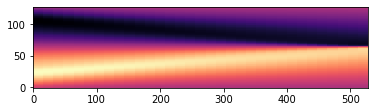

In [50]:
# a = session.run(grid_u)
# a = a[0,:,:,0].transpose() # ; print(a.shape)
# pylab.imshow(a, origin='lower', cmap='magma')
show_state(grid_u)

Let's compare solution at $t=0$
Actually not that great... max only at 0.5, even with 10k iters (shock gets better though), almost at 0.75 after 100k w more points

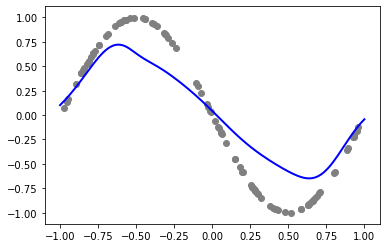

In [62]:
u = session.run(grid_u)
u0 = u[0,:,0,0]

import matplotlib.pyplot as plt
fig = plt.figure().gca()
fig.scatter(x_bc[0:100], u_bc[0:100], color='gray')
fig.plot(np.linspace(-1,1,len(u0)), u0, lw=2, color='blue')
#fig.plot(ini[:,0], ini[:,1], lw=2, color='green')


In [59]:
#print(x_bc[0:100])
#print(u_bc[0:100])

# fig = plt.figure().gca()
# #fig.plot(range(len(u0)), u0, lw=0.5, color='blue')
# fig.scatter(x_bc[0:100], u_bc[0:100], lw=0.1, color='green')

# forward test w Burgers
#domain = Domain([64, 64], boundaries=PERIODIC, box=box[0:100, 0:100])
#world.add(BurgersVelocity(domain, velocity=Noise(channels=domain.rank) * 2), physics=Burgers())

ini = np.asarray( [[x, - math.sin(np.pi * x)] for x in np.linspace(-1,1,16)] )
print(ini)

[[-1.00000000e+00  1.22464680e-16]
 [-8.66666667e-01  4.06736643e-01]
 [-7.33333333e-01  7.43144825e-01]
 [-6.00000000e-01  9.51056516e-01]
 [-4.66666667e-01  9.94521895e-01]
 [-3.33333333e-01  8.66025404e-01]
 [-2.00000000e-01  5.87785252e-01]
 [-6.66666667e-02  2.07911691e-01]
 [ 6.66666667e-02 -2.07911691e-01]
 [ 2.00000000e-01 -5.87785252e-01]
 [ 3.33333333e-01 -8.66025404e-01]
 [ 4.66666667e-01 -9.94521895e-01]
 [ 6.00000000e-01 -9.51056516e-01]
 [ 7.33333333e-01 -7.43144825e-01]
 [ 8.66666667e-01 -4.06736643e-01]
 [ 1.00000000e+00 -1.22464680e-16]]
